In [13]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
# from keras.utils.np_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import Callback
from keras.optimizers import Adam, RMSprop

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# data pre-processing
# normalize the input data
x_train = x_train.reshape(*x_train.shape, 1) / 255.    # normalize
x_test = x_test.reshape(*x_test.shape, 1) / 255.      # normalize

# one-hot output data
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [20]:
def cnn():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))

    model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])
    return model

model = cnn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)         

Epoch 1/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0368 - accuracy: 0.9897 - val_loss: 0.0176 - val_accuracy: 0.9942
Epoch 2/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.0183 - val_accuracy: 0.9937
Epoch 3/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0305 - accuracy: 0.9909 - val_loss: 0.0208 - val_accuracy: 0.9941
Epoch 4/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0287 - accuracy: 0.9917 - val_loss: 0.0180 - val_accuracy: 0.9950
Epoch 5/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.0198 - val_accuracy: 0.9947
Epoch 6/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0248 - accuracy: 0.9921 - val_loss: 0.0215 - val_accuracy: 0.9931
Epoch 7/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0252 - accuracy: 0.9927 - val_loss: 0.0208 - val_accuracy:

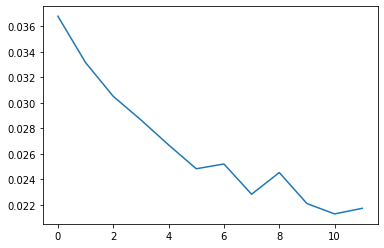

In [6]:
hist = model.fit(x_train, y_train, 
          validation_data = (x_test,y_test),
          epochs=12)
plt.plot(hist.history["loss"])

# visualize the weights

2
[(3, 3, 32, 64), (64,)]


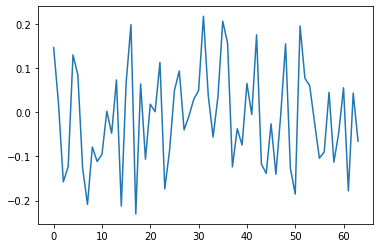

In [11]:
w = model.layers[4].get_weights()
print(len(w))
print([w[i].shape for i in range(len(w))])
# (filter_0, filter_1, n_channels, n_filters)
plt.plot(w[1].ravel())

# Model Weights change curve

In [54]:
model = cnn()

In [55]:
class RecordWeights(Callback):

    def __init__(self, i_layer, i_weight, name_layer, verbose=False):
        super(RecordWeights, self).__init__()
        self.i_layer = i_layer
        self.name_layer = name_layer
        self.i_weight = i_weight

        self.verbose = verbose
        
    def on_train_begin(self, epoch, logs=None):
        self.on_epoch_end(epoch, logs=logs)

    def on_epoch_end(self, epoch, logs=None):
        w = self.model.layers[self.i_layer].get_weights()[self.i_weight]
        self.model.history.history.setdefault("w_" + self.name_layer, []).append(w)

        if self.verbose:
            print("weights on layer {}({}): {}".format(self.i_layer, self.name_layer, w))

    @staticmethod
    def plot_w(names_layer, history: dict):
        """

        :param names_layer: Str or List[str], same name_layer string input in __init__()
        :param history:
        :return:
        """
        if isinstance(names_layer, str):
            names_layer = [names_layer]

        names_layer = ["w_" + name for name in names_layer]
        for name in names_layer:
            epochs = len(history[name])
            alphas = np.linspace(0.1, 1, epochs)

            plt.figure(figsize=(30, 10))
            plt.plot(history[name][0].ravel(), c="g")
            for i in range(1, epochs - 1):
                plt.plot(history[name][i].ravel(), alpha=alphas[i], c="b")
            plt.plot(history[name][-1].ravel(), c="r")
            plt.title("weights change on layer {}".format(name))
            plt.show()

In [62]:
%matplotlib inline

In [56]:
hist = model.fit(x_train, y_train, 
          validation_data = (x_test,y_test),
          epochs=50,
                callbacks=[RecordWeights(4, 1, "b2")])


Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3560 - accuracy: 0.8865 - val_loss: 0.0354 - val_accuracy: 0.9887
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.0250 - val_accuracy: 0.9917
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0494 - accuracy: 0.9856 - val_loss: 0.0228 - val_accuracy: 0.9924
Epoch 4/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0411 - accuracy: 0.9876 - val_loss: 0.0232 - val_accuracy: 0.9923
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0342 - accuracy: 0.9894 - val_loss: 0.0202 - val_accuracy: 0.9929
Epoch 6/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0317 - accuracy: 0.9909 - val_loss: 0.0178 - val_accuracy: 0.9942
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0294 - accuracy: 0.9915 - val_loss: 0.0187 - val_accuracy:

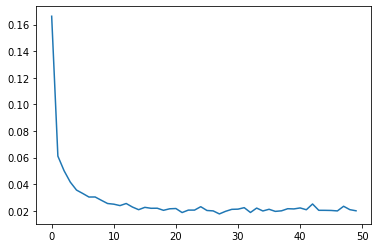

In [64]:
plt.plot(hist.history["loss"])
plt.show()

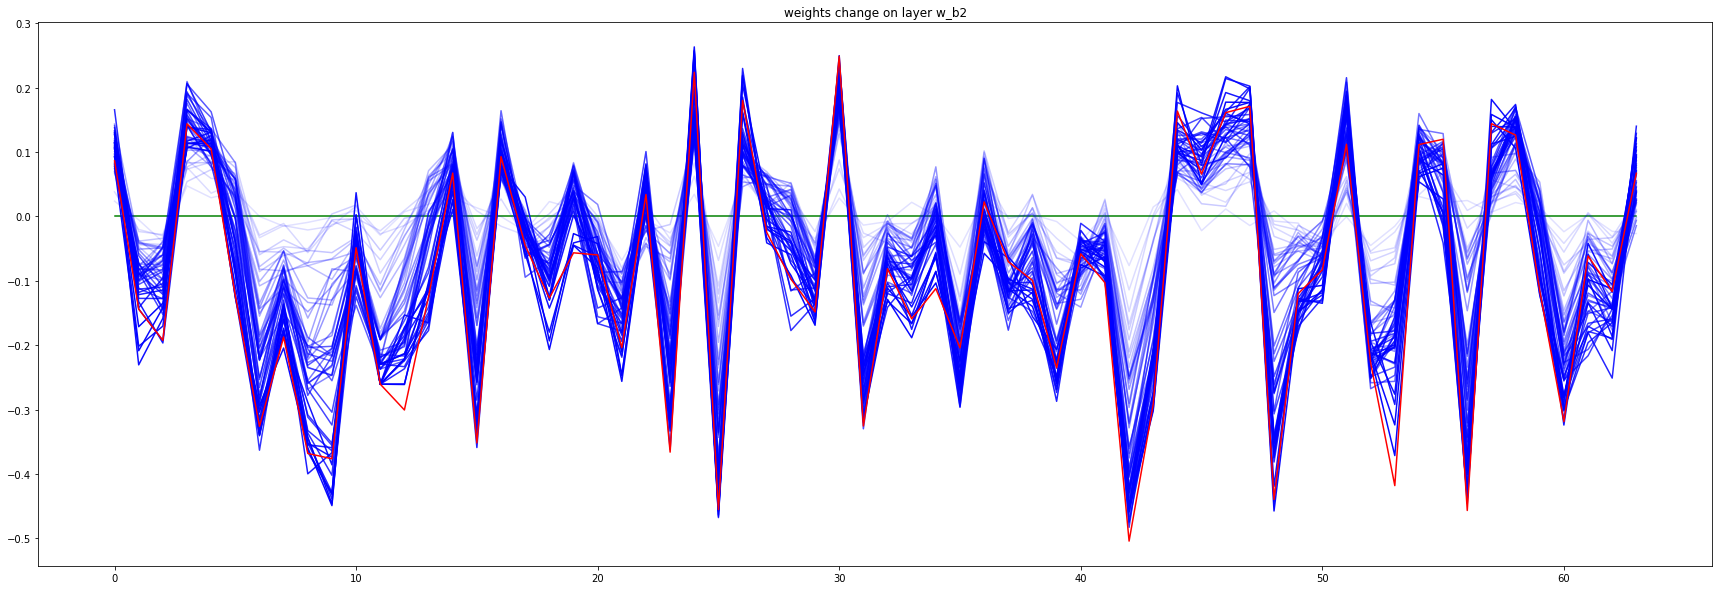

In [63]:
RecordWeights.plot_w(["b2"], hist.history)

# Model Weights change curve in 3D

In [58]:

def plot_w_3d(names_layer, history: dict):
    """

    :param names_layer: Str or List[str], same name_layer string input in __init__()
    :param history:
    :return:
    """
    if isinstance(names_layer, str):
        names_layer = [names_layer]

    names_layer = ["w_" + name for name in names_layer]
    for name in names_layer:
        epochs = len(history[name])
        alphas = np.linspace(0.05, 1, epochs)

        n_weights = len(history[name][0].ravel())            
        x = np.arange(n_weights)
        y = np.arange(epochs)
        X, Y = np.meshgrid(x, y)

        Z = np.array(history[name])

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

        # Plot the surface.
        colors =plt.cm.magma( (Y-Y.min())/float((Y-Y.min()).max()) )
        surf = ax.plot_surface(X, Y, Z, facecolors=colors,
                               linewidth=0,
                               antialiased=False)
        ax.set_xlabel('$Weights$', fontsize=20)
        ax.set_ylabel('$Epochs$', fontsize=20)

        plt.show()
        
def plot_w_3d2(names_layer, history: dict):
    """

    :param names_layer: Str or List[str], same name_layer string input in __init__()
    :param history:
    :return:
    """
    if isinstance(names_layer, str):
        names_layer = [names_layer]

    names_layer = ["w_" + name for name in names_layer]
    for name in names_layer:
        epochs = len(history[name])
        alphas = np.linspace(0.05, 1, epochs)

        n_weights = len(history[name][0].ravel())            
        x = np.arange(epochs)
        y = np.arange(n_weights)
        X, Y = np.meshgrid(x, y)

        Z = np.array(history[name]).T

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

        # Plot the surface.
        colors =plt.cm.magma( (X-X.min())/float((X-X.min()).max()) )
        surf = ax.plot_surface(X, Y, Z, facecolors=colors,
                               linewidth=1,
                               antialiased=False)
        ax.set_xlabel('$Epochs$', fontsize=20)
        ax.set_ylabel('$Weights$', fontsize=20)

        plt.show()

In [59]:
%matplotlib qt

In [60]:
plot_w_3d2(["b2"], hist.history)